In [1]:
# First, I import my libraries
import urllib.request, json 
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch

In [2]:
df = pd.DataFrame(
    {'Park': ['Castaic Lake State Recreation Area', 
              'Central Park', 
              'El Dorado Regional Park East', 
              'El Dorado Regional Park West', 
              'Elysian Park', 
              'Ernest E. Debs Regional Park', 
              'Frank Bonelli Regional Park',
              'Griffith Park 1',
              'Griffith Park 2',
              'Hahamonga Watershed Park',
              'Hansen Dam Park',
              'Heartwell Park',
              'Ken Malloy Harbor Regional Park',
              'Kenneth Hahn State Recreation Area',
              'Peter F. Schabarum Regional County Park',
              'San Dimas Canyon Community Regional Park 1',
              'San Dimas Canyon Community Regional Park 2',
              'Santa Fe Dam Recreation Area',
              'Sepulveda Basin Recreation Area 1',
              'Sepulveda Basin Recreation Area 2',
              'Whittier Narrows Recreation Area 1',
              'Whittier Narrows Recreation Area 2'
             ],
     'Latitude': [34.5347, 34.4341, 33.8097, 33.8072, 34.0820, 34.0912, 34.0772, 34.1170, 34.1093, 34.1943, 34.2708, 33.8306, 33.7823, 34.0123, 33.9904, 34.1292, 34.1274, 34.1120, 34.1744, 34.1857, 34.0474, 34.0374],
     'Longitude': [-118.6108, -118.5226, -118.0868, -118.0946, -118.2496, -118.1932, -117.8101, -118.2979, -118.3076, -118.1777, -118.3899, -118.1197, -118.2955, -118.3718, -117.9290, -117.7951, -117.7930,  -117.9403, -118.5020, -118.4835, -118.0648, -118.0641]})


In [3]:
df

Park  Latitude  Longitude
0           Castaic Lake State Recreation Area   34.5347  -118.6108
1                                 Central Park   34.4341  -118.5226
2                 El Dorado Regional Park East   33.8097  -118.0868
3                 El Dorado Regional Park West   33.8072  -118.0946
4                                 Elysian Park   34.0820  -118.2496
5                 Ernest E. Debs Regional Park   34.0912  -118.1932
6                  Frank Bonelli Regional Park   34.0772  -117.8101
7                              Griffith Park 1   34.1170  -118.2979
8                              Griffith Park 2   34.1093  -118.3076
9                     Hahamonga Watershed Park   34.1943  -118.1777
10                             Hansen Dam Park   34.2708  -118.3899
11                              Heartwell Park   33.8306  -118.1197
12             Ken Malloy Harbor Regional Park   33.7823  -118.2955
13          Kenneth Hahn State Recreation Area   34.0123  -118.3718
14     Peter F. Schabarum Regional County Park   33.9904  -117.9290
15  San Dimas Canyon Community Regional Park 1   34.1292  -117.7951
16  San Dimas Canyon Community Regional Park 2   34.1274  -117.7930
17                Santa Fe Dam Recreation Area   34.1120  -117.9403
18           Sepulveda Basin Recreation Area 1   34.1744  -118.5020
19           Sepulveda Basin Recreation Area 2   34.1857  -118.4835
20          Whittier Narrows Recreation Area 1   34.0474  -118.0648
21          Whittier Narrows Recreation Area 2   34.0374  -118.0641

In [4]:
gdf = gpd.GeoDataFrame(df)
                       

In [5]:
network_type = 'walk'
trip_times = [15]
meters_per_minute = 75
#define the function
##I commented out the intermediate plotting outputs, so the only thing this function will produce is the final isochrone map for each location
def isomap(gdf):
    G = ox.graph.graph_from_point(place, dist=1000, dist_type='bbox', network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    G = ox.project_graph(G, to_crs='epsg:3857')
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    
    minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

    iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                    cmap='viridis', 
                                    start=0, 
                                    return_hex=True)

    trip_times.sort(reverse=True)
    time_color = list(zip(trip_times, iso_colors))
    
    def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
        isochrone_polys = []
    
        for trip_time in sorted(trip_times, reverse=True):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

            node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
            nodes_gdf = gpd.GeoDataFrame({'id': list(subgraph.nodes)}, geometry=node_points)
            nodes_gdf = nodes_gdf.set_index('id')

            edge_lines = []
            for n_fr, n_to in subgraph.edges():
                f = nodes_gdf.loc[n_fr].geometry
                t = nodes_gdf.loc[n_to].geometry
                edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
                edge_lines.append(edge_lookup)

            n = nodes_gdf.buffer(node_buff).geometry
            e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
            all_gs = list(n) + list(e)
            new_iso = gpd.GeoSeries(all_gs).unary_union
            
            # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
            if infill:
                new_iso = Polygon(new_iso.exterior)
            isochrone_polys.append(new_iso)
        return isochrone_polys

    isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
    better_isos = gpd.GeoDataFrame()
    better_isos['geometry'] = None
    
    trip_times.sort(reverse=True)
    
    for i in range(len(isochrone_polys)):
        better_isos.loc[i,'geometry'] = isochrone_polys[i]
        better_isos.loc[i,'time'] =  str(trip_times[i]) + ' mins'

    fig, ax = plt.subplots(figsize=(10,15))

# add the isochrones
    better_isos.plot(alpha=0.4, 
                ax=ax, 
                column='time', 
                cmap='viridis', 
                edgecolor='white',
                 legend=True,
                zorder=20)

# add the center node in red
    gdf_nodes.loc[[center_node]].plot(ax=ax,color='r', zorder=30)

# add all nodes
# gdf_nodes.plot(ax=ax, 
#                markersize=1, 
#                zorder=1)

# add the edges
    gdf_edges.plot(ax=ax,
               linewidth=0.5,
               alpha=0.4,
               zorder=10)

# hide the axis
    ax.axis('off')

# give it a title
    ax.set_title('Walking areas from ' + row['Park'])

# add the basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.Voyager)

<ipython-input-5-5e70aa194c76>:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,15))
<ipython-input-5-5e70aa194c76>:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,15))


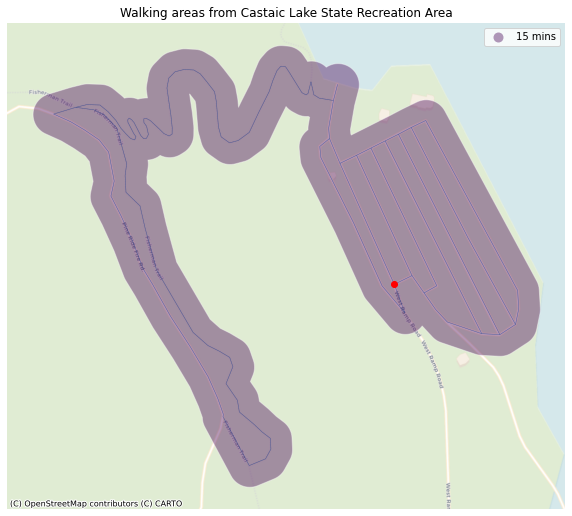

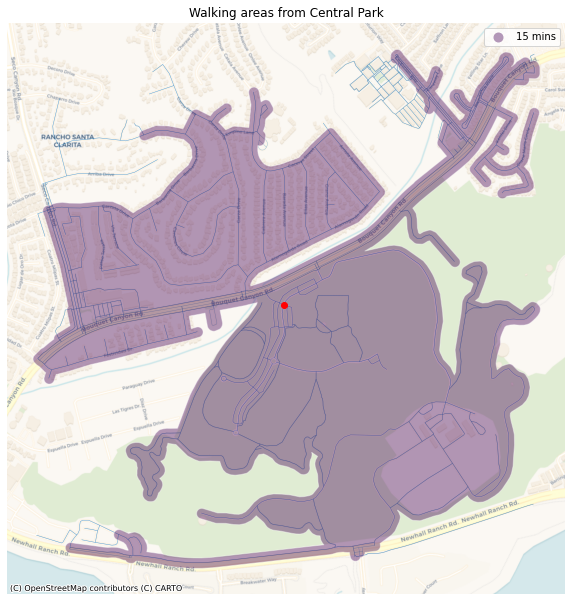

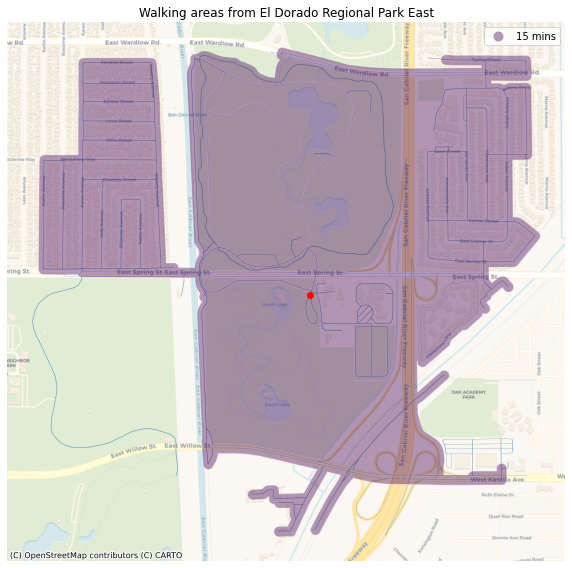

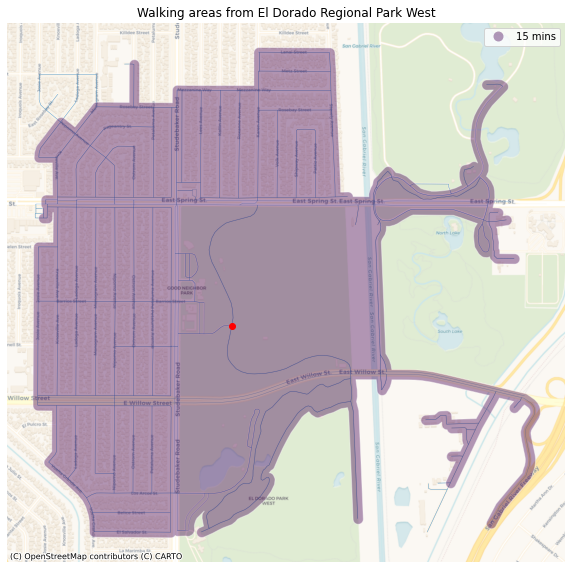

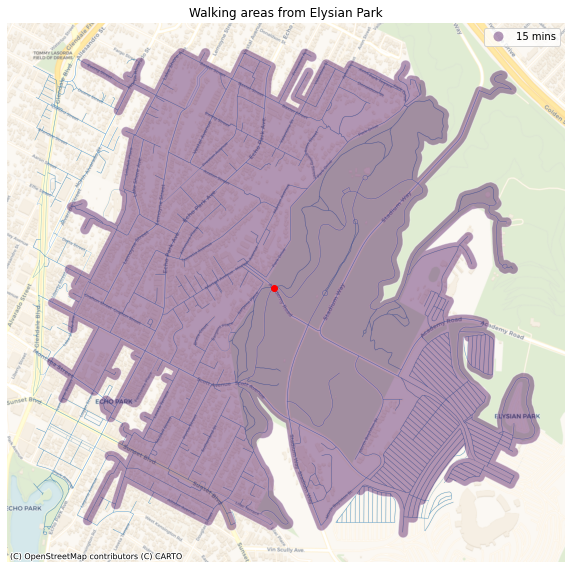

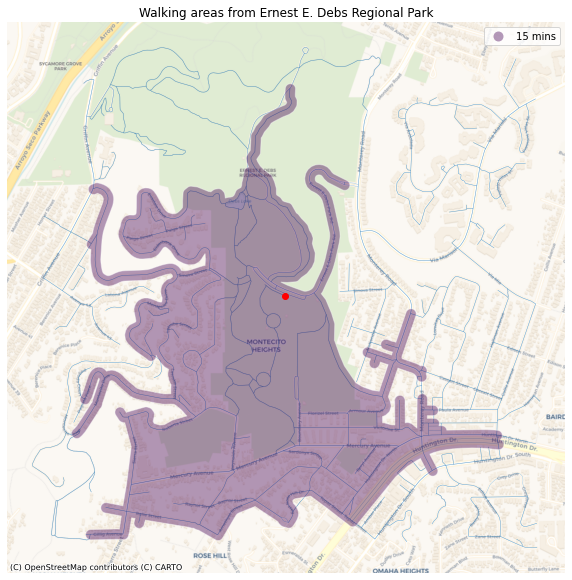

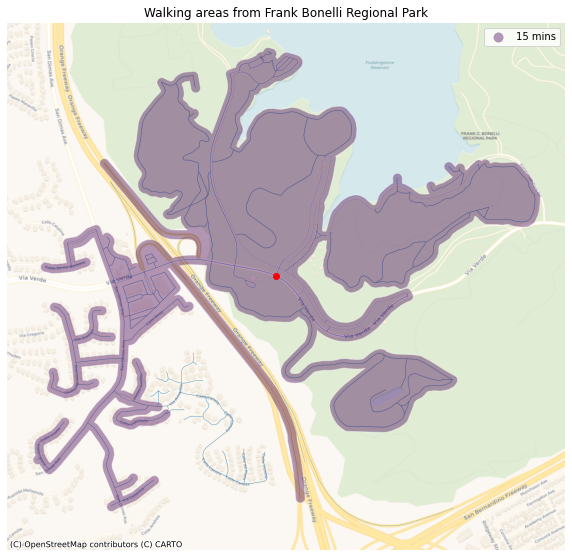

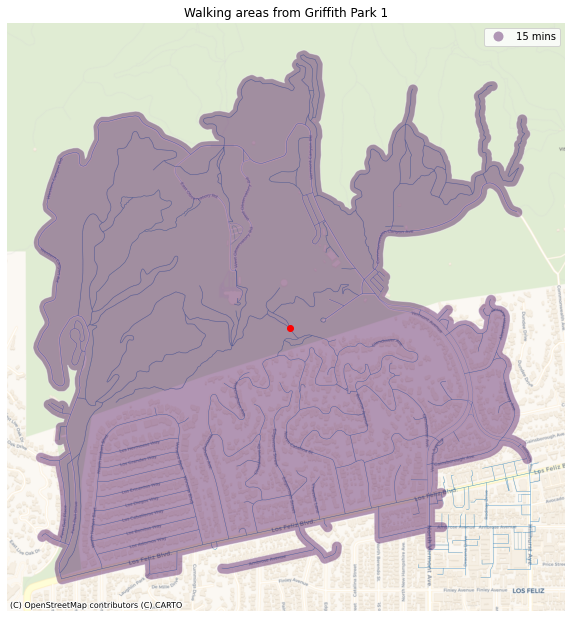

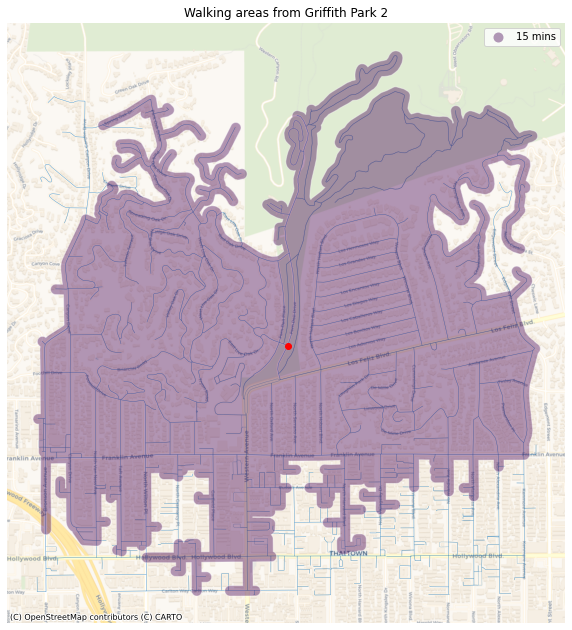

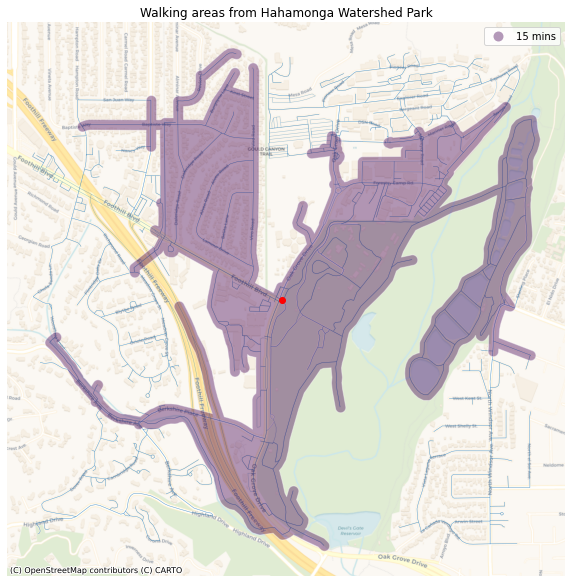

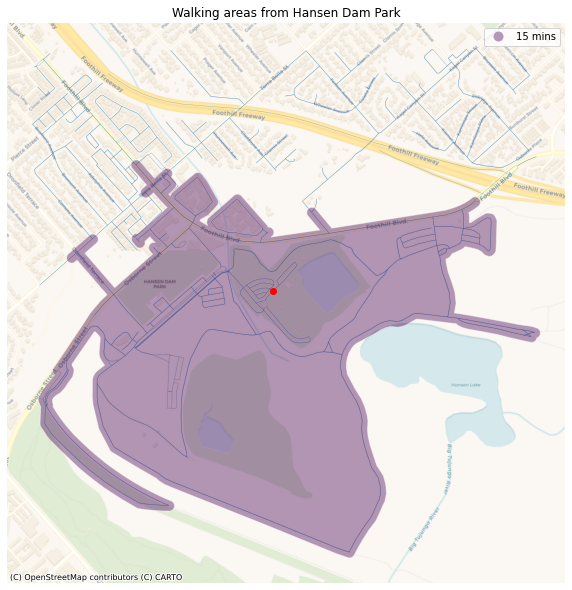

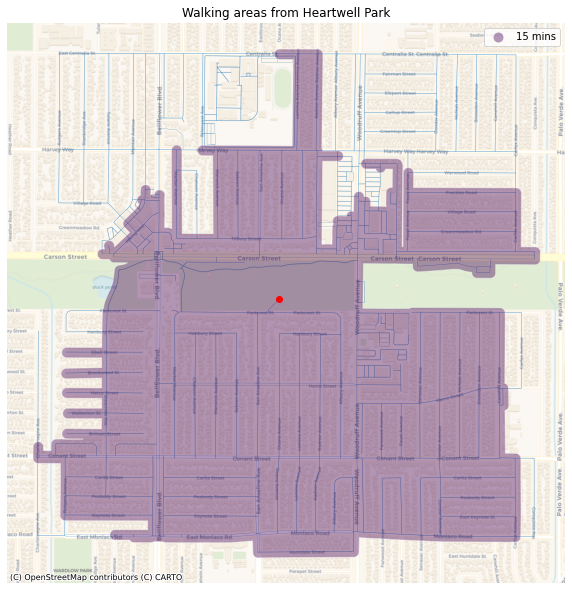

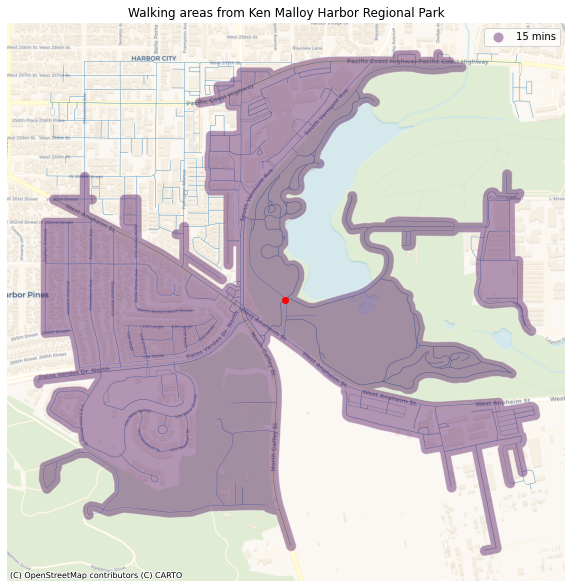

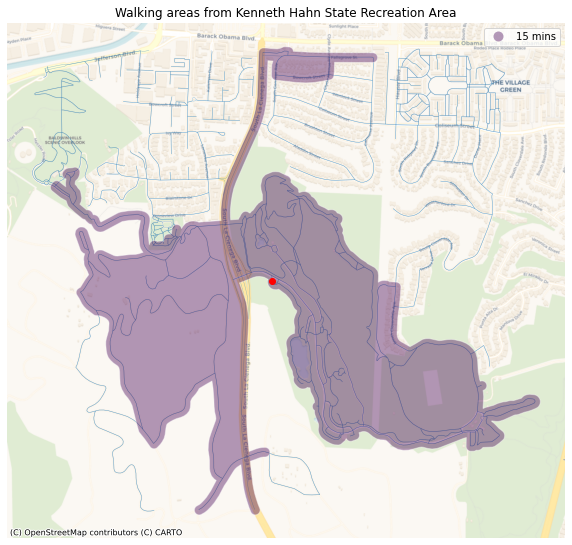

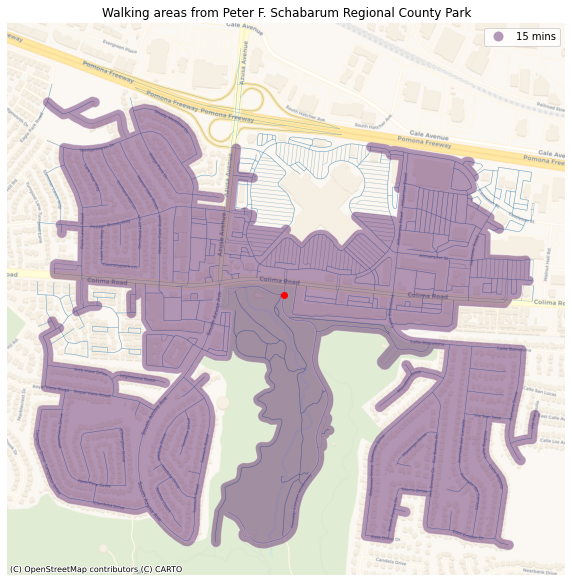

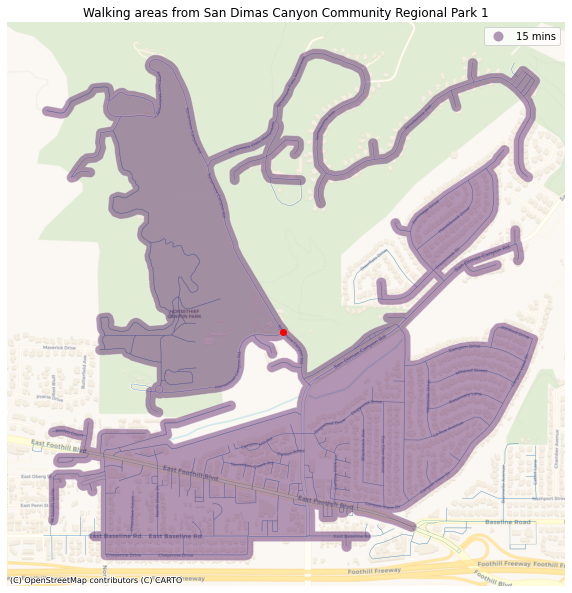

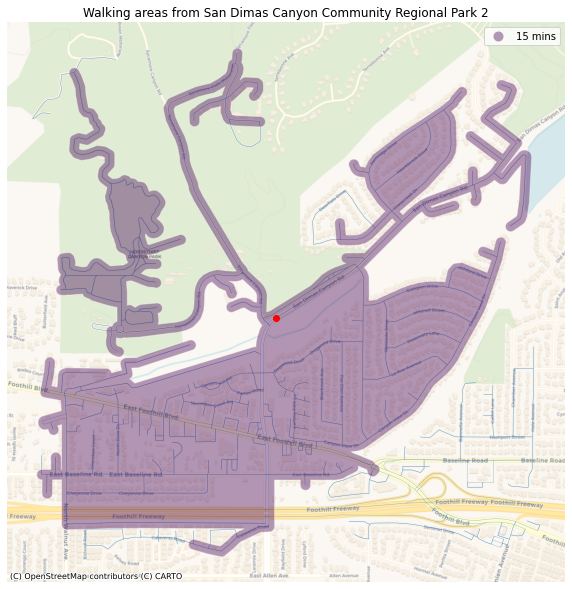

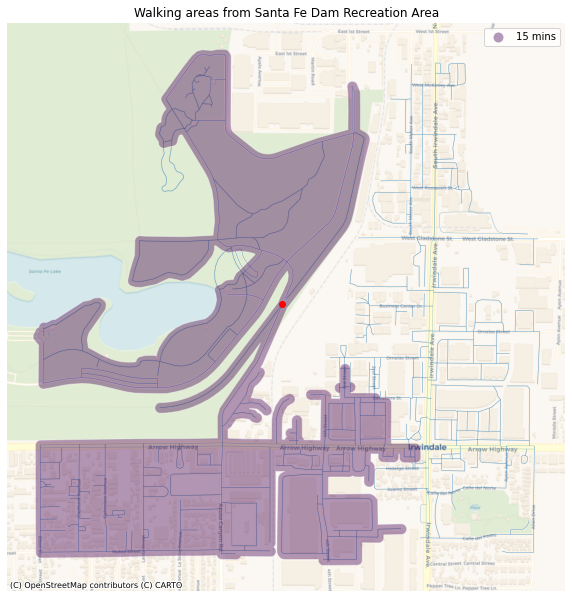

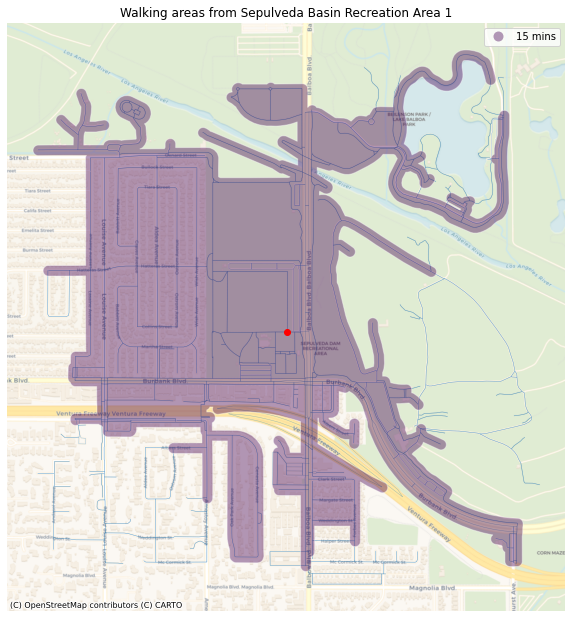

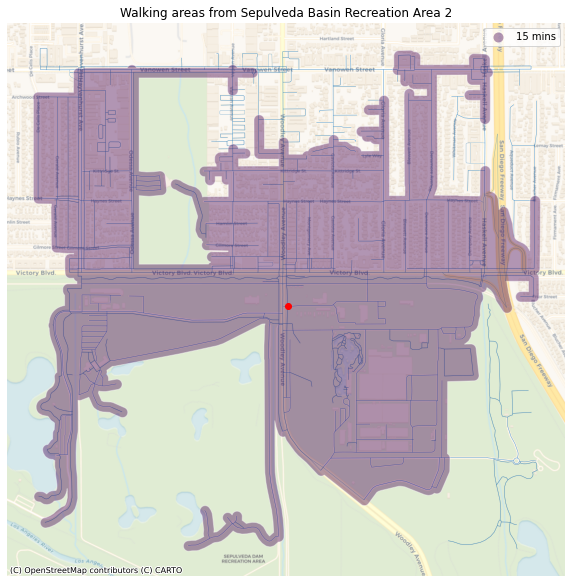

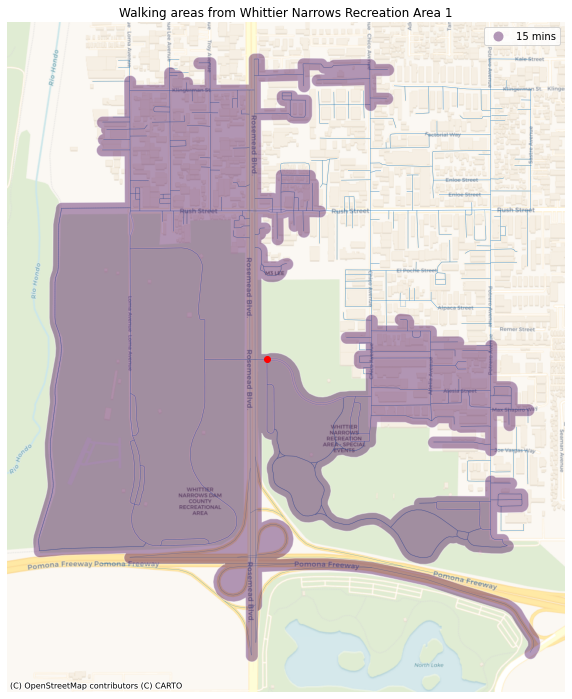

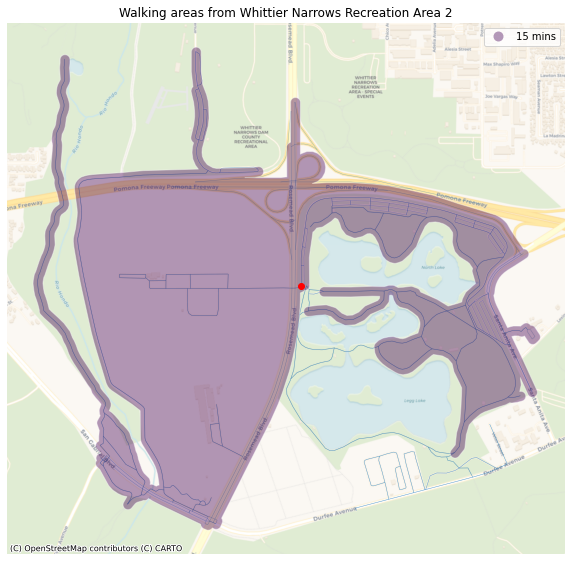

In [6]:
for index,row in gdf.iterrows():
    place = (row['Latitude'],row['Longitude'])
    isomap(gdf)